# Ett Machine Learning exempel

# Colab
Eftersom vi ska jobba med Machine Learning behöver vi en GPU (eller TPU server). Här ska vi använda oss av Colab (förkortning för Colaboratory), en gratis Jupyter miljö från Google.

Jag kommer skärmdela ett dokument, för att följa med:

- Gå till https://colab.research.google.com
- Välj `File` > `Open Notebook`. Välj `GitHub`-fliken. Klistra in `https://github.com/mejsla/vassare-jupyter/blob/main/ml-example.ipynb` (dela i chat).


## Kommande studiecirkel
Vi på Mejsla kommer att under våren anordna en studiecirkel där vi går igenom innehållet i boken [Deep Learning for Coders with fastai and PyTorch: AI Applications Without a PhD](https://course.fast.ai/).

Mer information om studiecirkeln hittas på [anmälningsformuläret](https://docs.google.com/forms/d/e/1FAIpQLSdMznAsCBbhE2s-5VWFgm9pecUM_jUB4VDltKixMfzIx5TfcA/viewform), som även kommer att mailas ut till alla deltagare efter mötet.

I denna Notebook visar vi ett första exempel från boken, där vi tränar en model så att den kan markera om en bild innehåller en hund eller en katt.




## Fastbook, fast.ai, PyTorch och TensorFlow
Vi börjar med att installera det Python paket, [fastbook](https://pypi.org/project/fastbook/), som hör till boken. Det innehåller funktioner som används genom boken och gör det enkelt att komma igång med exempel.

Boken använder sig av [fast.ai](https://www.fast.ai/) - något som kan ses via dess [requirements.txt](https://github.com/fastai/fastbook/blob/master/requirements.txt) fil som listar beroenden - vilket är ett ramverk för deep learning byggt ovanpå (gör det lättare att använda) [PyTorch](https://pytorch.org/), vilket är det framework som gör det tunga jobbet.

PyTorch, främst utvecklat av Facebook's AI Research lab, är ett alternativ till [TensorFlow](https://www.tensorflow.org/), vilket är ett äldre och mer känt bibliotek för machine learning från Google - men underliggande begrepp och teori är överförbar mellan projekten.

Som boken nämner händer mycket saker snabbt inom utveckling i allmänhet och Machine Learning i synnerhet. Vilka bibliotek och ramverk som kommer att användas kommer med stor sannolikhet ändras över tid, men underliggande förståelse för tekniker och begrepp kommer göra det lättare att anpassa sig till och använda till nya verktyg inom området.

Setup-koden kommer att använda Google Drive, och kommer därför be om tillgång till denna:


In [ ]:
!pip install -Uqq fastbook
from fastbook import *
setup_book()

## En första modell

Nedan följer en kodsnutt som trots dess korthet är ett fullständigt system för att skapa och träna en state-of-the-art modell för att känna igen katter eller hundar.

Följande sker:

1. En datamängd vid namn [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) som innehåller 7,349 bilder av katter och hundar från 37 raser kommer laddas ner från fast.ai:s samling av data till den GPU server som används. (Öppna länken till Oxford-IIIT Pet Dataset i browser och visa!)
2. En *förtränad modell* (pretrained model) som redan har tränats på 1.3 miljoner bilder och konstaterats prestera väl, kommer att laddas ner. Namnet på modellen är `resnet34`.
3. Den förtränade modellen kommer att anpassas (*fine-tuned*) användandes *transfer learning* för att skapa en modell som är specifikt anpassad för att känna igenom katter och hundar.

In [ ]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)/'images'

def is_cat(x):
  return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

> OBS: Det kommer ta några minuter att ladda ner och anpassa modellen. Kör den i förväg!

# Bedöma modells effektivitet och testa det manuellt

Hur ska vi bedöma hur bra modellen presterar?

Sista kolumnen i tabellen visar error rate, den andel av bilderna som klassificerades inkorrekt.

Som ses av siffran är modellen effektiv trots snabb tid för anpassning, och faktiskt bättre än vad någon skulle kunna prestera för säg 10 år sen.

För att manuellt bekräfta att det fungerar, låt oss ladda upp en bild (använda google sökning efter hund eller katt bilder):

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Efter att ha laddat upp en bild med Upload-knappen ovan kan vi använda modellen för att klassificera bilden:

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


För att förklara vad vi gjort ska vi backa ut ett steg.

## Vad är Machine Learning?


*Machine learning* är, likt vanlig programmering, ett sätt att få datorer at utföra ett önskat jobb. Med vanlig programmering menar vi modellen där vi exakt beskriver de steg ett program ska ta för att givet input producera ett visst output:


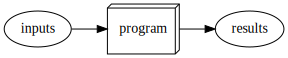

In [ ]:
gv('''program[shape=box3d width=1 height=0.7] inputs->program->results''')

Men för att känna igen objekt i en bild är det svårt - vad är egentligen stegen våra hjärnor tar för att känna igen om en bild representerar en hund eller en katt? Hur skulle man översätta det till kod? Svaret är att det är svårt - det händer i våra hjärnor utan att vi är medvetna om exakta stegen.

På 40-talet börjades det formuleras ett annat sätt för datorer att utföra uppgifter som kallades *machine learning*. I en klassisk skrift från 1962,  "Artificial Intelligence: A Frontier of Automation", skrevs det (fritt översatt):

> Att programmera en dator för en sådan uppgift är en svår (om inte omöjlig) uppgift. Inte nödvändigtvis för att en inneboende komplexitet i problemet, utan för nödvändigheten att i detalj skriva ner varje steg. Datorer, som de flesta programmerare ser det, är enorma idioter, inte enorma hjärnor.


Den grundläggande idén var att istället för att i detalj beskriva hur problemet ska lösas, så visar vi programmet exempel på problem att lösa, och låter det sedan självt koma på lösningar.

Det här visade sig snabbt lovande i initiala experiment - ett program för damspel, checkers, blev statsmästaste i Connecticut 1961.

För att sammanfatta begrepp som användes:

- Vikter (`weights`) är variabler som ges till modellen. Tillsammans med input-datat definierar de vilken output en viss modell ger.

De kan ses som en form av input:

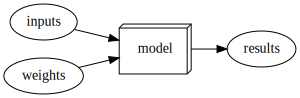

In [ ]:
gv('''model[shape=box3d width=1 height=0.7] inputs->model->results; weights->model''')

Vi har här också ändrat namnet från *program* till *model*, vilket är modernare namngivning och visar att det rör sig om en speciell typ av program skiljt från traditionella datorprogram.

En *model* är ett specill typ av program som kan göra *olika saker* beroende på de *weights* som anges.

- I dam-spelet kan olika vikter vara olika strategier.
- I våran hund&katt igenkännare är vikter det som erhållts från vår anpassning av en generell bild-klassifierare till att just känna igen katter och hundar.

För att en model ska kunna lära sig behövs dessutom ett *automatiskt sätt att testa effektiviteten hos en viss uppsättning vikter*.

- I fallet med damspelet är effektiviteten hur väl modellen spelade, och ett automatiskt sätt att testa detta skulle kunna vara att låta två modeller spela med varandra.
- I våran hund&katt igenkännare så använda vi oss av ett *facit* - någon har redan tagit sig tid att manuellt markera vilka bilder som avbildade katter och vilka som avbildade hundar, och markerat detta genom att låta filnamnet börja med stor bokstav eller inte.

Slutligen så behövs en *mekanism för att uppdatera vikterna för att maximera effektiviteten*. Detaljerna här är icke triviala, men vi skulle kunna tänka oss att vi tittar på skillnader mellan en vinnande modell och en som förlorar, och ändra vikterna en bit åt det håll som vinnande modellen är i.


Nedan visas en fullständig modell av det vi gått igenom:

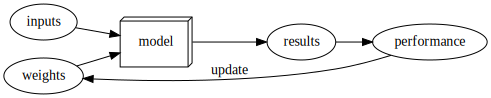

In [ ]:
gv('''ordering=in model[shape=box3d width=1 height=0.7] inputs->model->results; weights->model; results->performance performance->weights[constraint=false label=update]''')

Lägg märke till skillnaden mellan modellens *resultat* (t.ex. de drag som sker i Dam-spelet) och dess *effektivitet* (t.ex. om det vinner ett spel, och isf hur snabbt).

När modellen väl har blivit tränad - dvs, när vi har bestämt oss för slutliga vikter, så kan vi se vikterna som del av modellen, och användandet av den därefter blir som visas nedan:

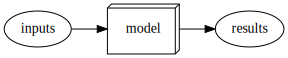

In [ ]:
gv('''model[shape=box3d width=1 height=0.7] inputs->model->results''')

Om vi jämför med den initiala modellen för ett traditionellt datorprogram ser vi att den ser likadan ut, med *program* utbytt mot *model*. Det är en trevlig egenskap:
- När väl modellen är tränad kan den användas som ett traditionellt program, utan att vara krångligare för den som anropar det.

För att sammanfatta definitionen:

> Machine Learning: The training of programs developed by allowing a computer to learn from its experience, rather than through manually coding the individual steps.

## Neurala nätverk
För ett Dam-spelande program kan vi skapa oss en bild av en möjlig modell, med olika strategier programmerade och vikter som påverkar hur dessa strategier väljs och t.ex. hur olika delar av brädet söks av.

Men, för bildigenkänning är det långt ifrån uppenbart hur en modell skulle kunna se ut.

Vi skulle vilja ha en typ av funktion som är så flexibel att det skulle kunna lösa ett godtyckligt problem enbart genom att variera dess vikter. Och även om det kan låta för bra för att vara sant finns det faktiskt en sådan funktion genom *neurala nätverk*, som härstammar ifrån en modell av hur neuroner i hjärnan fungerar.

![Neuroner](https://github.com/fastai/fastbook/raw/fb570779062177662fbfde0f5dbb1e9f08dabbee/images/chapter7_neuron.png)

Neurala nätverk är självklart inte en magisk lösning på problem, men ett kraftfullt verktyg som vi kommer att studera närmare i studiecirkeln. Här nöjer vi oss att konstatera att neurala nätverk är en typ av Machine learning modell.

## Begränsningar hos Machine learning

Från ovanstående förståelse kan vi erhålla några fundamentala saker kring träning av en modell:

- En modell kan inte skapas utan data.
- En modell kan bara läras att agera på mönstrena som ses i den input data som används i träningen av den.
- Det är inte tillräckligt att ha exempel på input data - vi behöver kategoriseringar av dena data också (i vårat hund&katt exempel så är inte bilder av hunder och katter tillräckligt - vi behöver en kategorisering av varje bild, som säger ifall bilden representerar en hund eller katt).

Det här innebär att ett problem ofta är just på kategoriserad data, inte på data i allmänhet. Rådata finns ofta, men kategoriserad data kan vara en bristvara.

## Etiska problem
En annan intressant aspekt med Machine learning och modellering är *feedback loops*, som är ett problem både med avseende på *korrekthet* och ur ett *etiskt* perspektiv.

Boken nämner exempel på en *positive feedback loop*, där användandet av en model gör att felaktigt vinklat data förstärks, varpå modellen uppdateras att bli ännu mer partisk:

- En model där antal arrestering per stadsdel över tid används för att förutsäga i vilka stadsdelar flest gripanden kommer att ske i framtiden.
- Ett problem här är att antalet gripanden inte behöver vara ett mått på brottslig aktivitet, utan kan avspegla partiskhet baserat på t.ex. fördomar eller gamla sanningar.
- Om polisen då använder denna model för att öka sin verksamhet i stadsdelar där det förväntas ske fler gripanden, kommer antalet gripanden öka än mer.
- Denna data matas tillbaks till modellen som blir än mer partisk.

Det här är ett intressant och viktig fråga, och boken som vi kommer att studera i studiecirkeln ägnar ett kapitel åt detta.
